In [31]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as scipystats
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from analysis.models.vr import RatCAVESession
from analysis.plots.placecells.F02_AB_cells import all_AB_cells, shift_plot, single_unit_plot
from analysis.plots.trajectory import arena_vs_animal_positions
from analysis.plots.placecells.utils import get_figure_size
from analysis.plots.placecells.draw import draw_occupancy, draw_place_field, draw_place_firing
from analysis.models.analytics import place_field_2D

from functools import reduce # only in Python 3

#import nbimporter
#from Utils import get_metrics, get_sessions_list, create_symlinks
from analysis.processing.utils import get_sessions_list, create_symlinks

In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Get sessions

In [33]:
s_type = 'SHIFT physical 30'
s_type = 'SHIFT physical AWAY'
s_type = 'SHIFT visual'
s_type = 'SHIFT both'
s_type = 'SHIFT physical 30 +dark'
s_type = 'GAIN 3 parts'

sessions_list = list(get_sessions_list(s_type))

exclude = [  # low occupancy
    ('003282', '2019-11-12_21-23-37'),
    ('003282', '2019-11-14_20-47-14')
]

for x in exclude:
    sessions_list.remove(x)

sessions_list

[('003281', '2019-11-17_15-34-04'),
 ('003281', '2019-11-20_15-15-05'),
 ('003282', '2019-11-08_17-35-28'),
 ('003282', '2019-11-19_08-18-21'),
 ('003282', '2019-11-07_22-05-39'),
 ('003281', '2019-11-07_21-41-36'),
 ('003282', '2019-11-17_15-59-58'),
 ('003282', '2019-11-20_11-41-38'),
 ('003282', '2019-12-03_19-51-34'),
 ('003282', '2019-11-12_15-29-13'),
 ('003282', '2019-11-13_12-54-37'),
 ('003282', '2019-11-11_13-04-49'),
 ('003282', '2019-11-13_22-18-19'),
 ('003282', '2019-11-22_10-16-28'),
 ('003282', '2019-11-12_20-24-17'),
 ('003282', '2019-11-26_21-58-57')]

In [ ]:
"""
VR bars
00910_2019-07-21_17-01-34_3_6

VR bars / new area
00908_2019-07-09_08-49-24_7_3
003281_2019-11-05_20-11-18_7_6_new_area

VR borders
00908_2019-07-08_17-46-20_6_4_VR_borders
00908_2019-07-08_17-46-20_6_3

VR floor
D_003281_2019-11-21_22-51-03_7_2_floor_cell
00908_2019-07-09_17-00-25_6_6_floor_cell

Arena
00908_2019-07-22_22-25-02_2_3
00908_2019-07-24_11-17-34_3_4



VISUAL


003909_2020-03-27_16-41-02_6_7 - some cells
2020-03-29_12-37-34 - some cells, dirty
003908_2020-04-01_12-19-12_3_2 - VR cell
003908_2020-04-06_21-41-46_5_2 - VR cell
003908_2020-04-15_19-18-36_2_3 - VR cell



VFG
2020-03-28_15-45-33 - many shifted, analysis needed
2020-04-07_13-56-00 - some shifted, analysis needed
2020-04-07_17-26-19 - some shifted, analysis needed
003908_2020-04-20_16-54-32_3_3 - many good to fix


BOTH
2020-03-28_18-36-22 good session
2020-04-08_11-39-51 good session



TO RESOLVE
003908_2020-03-27_17-26-53_2_2
003908_2020-04-20_16-54-32_1_5
003908_2020-04-20_16-54-32_2_2
003908_2020-04-20_16-54-32_3_4
003908_2020-04-20_16-54-32_4_2

shank problem
003908_2020-04-21_13-54-35_4_2
003908_2020-04-21_13-54-35_3_2

"""

# Loading data

In [34]:
source = '/home/andrey/storage2/andrey/data/processed'

total = len(sessions_list)

# many sessions detected above
sessions = list(sessions_list)

# or a single session
#sessions = [['003282', '2019-11-12_21-23-37']]


meanFR = {}
for i, (animal, session_id) in enumerate(sessions):

    # loading unit groups
    sessionpath = os.path.join(source, animal, session_id)
    h5file = os.path.join(sessionpath, 'all.h5')
    with h5py.File(h5file, 'r') as f:
        unit_groups = [x for x in f['units']]
        
    # processing single units
    unit_MFR = {}
    for unit_group_name in unit_groups:
        
        conditions = ['A', 'AB', 'B', 'BC', 'C']
        electrode = unit_group_name.split('_')[0]
        unit = unit_group_name.split('_')[1]
        
        with h5py.File(h5file, 'r+') as f:
            unit_group = f['units']['%s_%s' % (electrode, unit)]
            
            data_for_cond = {}
            for cond in conditions:
                occup = np.array(unit_group[cond+'_occupancy'])

                data_for_cond[cond] = {
                    'mfr': unit_group[cond+'_place_field'].attrs['mean_firing_rate'],
                    'sic': unit_group[cond+'_place_field'].attrs['information_content'],
                    'occupancy': len(np.where(occup > 0)[0]) / occup.size
                }
                
                
        unit_MFR[unit_group_name] = data_for_cond
        
    meanFR[session_id] = unit_MFR

# Mean FR

In [8]:
occup_criteria = 0.5  # 50% of visited bins
low_occup_sessions = {}

for session_id, unit_MFR in meanFR.items():
    first = list(unit_MFR.values())[0]

    ocA = first['A']['occupancy']
    ocB = first['B']['occupancy']
    ocC = first['C']['occupancy']
    
    if ocA < occup_criteria or ocB < occup_criteria or ocC < occup_criteria:
        low_occup_sessions[session_id] = [ocA, ocB, ocC]
    
collection = []
for session, data in low_occup_sessions.items():
    collection.append([session, round(data[0], 2), round(data[1], 2), round(data[2], 2)])
    
collection

[]

In [9]:
delta_mfr = []
data_occup = []

for session_id, unit_MFR in meanFR.items():
    first = list(unit_MFR.values())[0]
    data_occup.append([
        first['A']['occupancy'],
        first['B']['occupancy'],
        first['C']['occupancy']
    ])

    # do not consider sessions with low occupancy
    if (np.array(data_occup)[-1] < occup_criteria).any():
        continue
        
    for name, data in unit_MFR.items():
        if data['A']['sic'] > 0.2:
            delta_mfr.append([
                data['A']['mfr'],
                data['B']['mfr'],
                data['C']['mfr']
            ])

delta_mfr = np.array(delta_mfr)
data_occup = np.array(data_occup)
len(delta_mfr), len(data_occup)

(265, 16)

(263, 263)

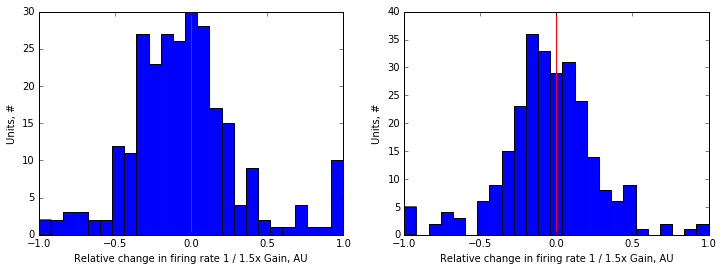

In [10]:
delta_AB = np.array([((delta[1] - delta[0])/(delta[1] + delta[0])) for delta in delta_mfr if (delta[1] + delta[0]) > 0])
delta_BC = np.array([((delta[2] - delta[1])/(delta[2] + delta[1])) for delta in delta_mfr if (delta[2] + delta[1]) > 0])

# delta_AB = (delta_mfr[:, 1] - delta_mfr[:, 0]) / (delta_mfr[:, 1] + delta_mfr[:, 0])
# delta_BC = (delta_mfr[:, 2] - delta_mfr[:, 1]) / (delta_mfr[:, 2] + delta_mfr[:, 1])

fig = figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.set_xlim(-1, 1)
ax.set_xlabel('Relative change in firing rate 1 / 1.5x Gain, AU')
ax.set_ylabel('Units, #')
ax.axvline(0, color='red')
# ax.axvline(-border, color='orange')
# ax.axvline(border, color='orange')
a1 = ax.hist(delta_AB, 25)

ax = fig.add_subplot(122)
ax.set_xlabel('Relative change in firing rate 1 / 1.5x Gain, AU')
ax.set_ylabel('Units, #')
ax.axvline(0, color='red')
a1 = ax.hist(delta_BC, 25)

len(delta_AB), len(delta_BC)

# Occupancy

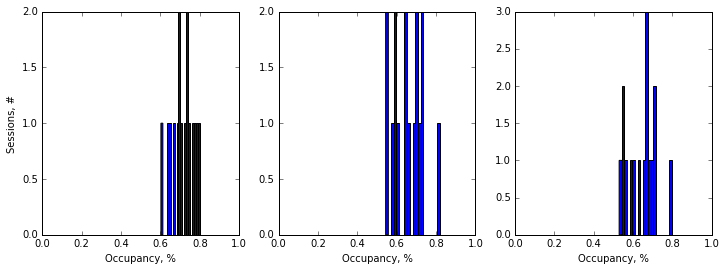

In [11]:
fig = figure(figsize=(12, 4))
bins = 20

ax = fig.add_subplot(131)
ax.set_xlabel('Occupancy, %')
ax.set_ylabel('Sessions, #')
ax.set_xlim(0, 1)
a1 = ax.hist(data_occup[:, 0], bins)

ax = fig.add_subplot(132)
ax.set_xlabel('Occupancy, %')
ax.set_xlim(0, 1)
a1 = ax.hist(data_occup[:, 1], bins)

ax = fig.add_subplot(133)
ax.set_xlabel('Occupancy, %')
ax.set_xlim(0, 1)
a1 = ax.hist(data_occup[:, 2], bins)

# Correlations A->B, 1->1.5x Gain

## computing stable fields

In [12]:
stable_fields = {}  # session, unit, field, [(fieldA_id, fieldB_id, overlap), (fieldA_id, fieldC_id, overlap)]
FRmin = 1.0
min_overlap = 0.2

for i, (animal, session_id) in enumerate(sessions):

    # loading unit groups
    sessionpath = os.path.join(source, animal, session_id)
    h5file = os.path.join(sessionpath, 'all.h5')
    with h5py.File(h5file, 'r') as f:
        unit_groups = [x for x in f['units']]
        unit_group = f['units'][unit_groups[0]]

        trajectory = np.array(f['animal_trajectory'])
        
    # processing single units
    all_units_matches = {}
    for unit_group_name in unit_groups:
        electrode = unit_group_name.split('_')[0]
        unit = unit_group_name.split('_')[1]
        
        with h5py.File(h5file, 'r+') as f:
            unit_group = f['units']['%s_%s' % (electrode, unit)]

            fieldsA = np.array(unit_group['A_fields'])
            fieldsB = np.array(unit_group['B_fields'])
            fieldsC = np.array(unit_group['C_fields'])

            fieldsACOMs = np.array(unit_group['A_fields_COMs']) if 'A_fields_COMs' in unit_group else None
            fieldsBCOMs = np.array(unit_group['B_fields_COMs']) if 'B_fields_COMs' in unit_group else None
            fieldsCCOMs = np.array(unit_group['C_fields_COMs']) if 'C_fields_COMs' in unit_group else None
            xy_range = np.array(unit_group.attrs['xy_range'])
            
            sicA = unit_group['A_place_field'].attrs['information_content']
            sicB = unit_group['B_place_field'].attrs['information_content']
            sicC = unit_group['C_place_field'].attrs['information_content']
            
            
        if sicA < 0.2 or sicB < 0.2 or sicC < 0.2:
            continue
            
        # processing single fields
        unit_matches = {}
        fieldCOMs = [fieldsACOMs, fieldsBCOMs, fieldsCCOMs]
        for field_A_id in [y for y in np.unique(fieldsA) if not y == 0]:

            peak_FRA = fieldsACOMs[fieldsACOMs[:, 0] == field_A_id][0][3] if fieldsACOMs is not None else 0
            if not peak_FRA > FRmin:
                continue
                
            # compute overlap with B and C
            field_matches = []
            for j, fieldsX in enumerate([fieldsB, fieldsC]):
                intersection_size = 0
                match = []
                
                for field_X_id in [x for x in np.unique(fieldsX) if not x == 0]:

                    # check field's firing rate
                    fieldCOM = fieldCOMs[j + 1]
                    peak_FRX = fieldCOM[fieldCOM[:, 0] == field_X_id][0][3] if fieldCOM is not None else 0
                    if not peak_FRX > FRmin:
                        continue

                    fA_idxs = np.where(np.flipud(fieldsA.T).flatten() == field_A_id)[0]
                    fX_idxs = np.where(np.flipud(fieldsX.T).flatten() == field_X_id)[0]
                    intersection_rel = len(np.intersect1d(fA_idxs, fX_idxs)) / ( (len(fA_idxs) + len(fX_idxs)) / 2 )

                    # exclude fields with no or little overlap
                    if intersection_rel > intersection_size and intersection_rel > min_overlap:
                        faCOM = fieldsACOMs[fieldsACOMs[:, 0] == field_A_id][0]
                        fxCOM = fieldCOM[fieldCOM[:, 0] == field_X_id][0]
                        y_shift = fxCOM[2] - faCOM[2]
                        
                        vlength_A = (fA_idxs[-1] - fA_idxs[0] ) / len(fieldsA)
                        vlength_X = (fX_idxs[-1] - fX_idxs[0] ) / len(fieldsX)
                        
                        # 0 - field A id, 1 - field X id, 2 - % overlap, 3 - Vert length A
                        # 4 - Vert length X, 5 - A COMy, 6 - A COMy, 7 - A-X COM shift
                        match = [field_A_id, field_X_id, intersection_rel, vlength_A, vlength_X, faCOM[2], fxCOM[2], y_shift]

                        intersection_size = intersection_rel
                
                # matches for fields in B, C
                if len(match) > 0:
                    field_matches.append(match)
                
            if len(field_matches) == 2:  # both B and C have field matching A
                unit_matches[field_A_id] = field_matches
        
        if len(unit_matches) > 0:
            all_units_matches[unit_group_name] = unit_matches
    
    if len(all_units_matches) > 0:
        stable_fields[session_id] = all_units_matches


## computing correlations

In [13]:
AB_corr = []
BC_corr = []
AC_corr = []
A_spiketrains = []
AB_spiketrains = []
B_spiketrains = []
BC_spiketrains = []
C_spiketrains = []
trajs = []  # a lot of duplicates, but
num_fields = []

# stable fields filter
stable_units_filter = []
for session_id, units in stable_fields.items():
    for unit_name in units.keys():
        stable_units_filter.append([session_id, int(unit_name.split('_')[0]), int(unit_name.split('_')[1])])

for i, (animal, session_id) in enumerate(sessions):

    # loading unit groups
    sessionpath = os.path.join(source, animal, session_id)
    h5file = os.path.join(sessionpath, 'all.h5')
    with h5py.File(h5file, 'r') as f:
        unit_groups = [x for x in f['units']]
        unit_group = f['units'][unit_groups[0]]

        trajectory = np.array(f['animal_trajectory'])
        
        A_indexes = np.array(f['A_indexes'])
        AB_indexes = np.array(f['AB_indexes'])
        B_indexes = np.array(f['B_indexes'])
        BC_indexes = np.array(f['BC_indexes'])
        C_indexes = np.array(f['C_indexes'])
        
        ocA = np.array(unit_group['A_occupancy'].attrs['ratio'])
        ocB = np.array(unit_group['B_occupancy'].attrs['ratio'])
        ocC = np.array(unit_group['C_occupancy'].attrs['ratio'])
            
    # FILTERING OUT LOW OCCUPANCY
    if ocA < occup_criteria or ocB < occup_criteria or ocC < occup_criteria:
        continue
    
    # processing single units
    for unit_group_name in unit_groups:
        electrode = unit_group_name.split('_')[0]
        unit = unit_group_name.split('_')[1]
        
#         if not [session_id, int(electrode), int(unit)] in stable_units_filter:
#             continue
        
        with h5py.File(h5file, 'r+') as f:
            unit_group = f['units']['%s_%s' % (electrode, unit)]

            fieldsACOMs = np.array(unit_group['A_fields_COMs']) if 'A_fields_COMs' in unit_group else None
            fieldsBCOMs = np.array(unit_group['B_fields_COMs']) if 'B_fields_COMs' in unit_group else None
            fieldsCCOMs = np.array(unit_group['C_fields_COMs']) if 'C_fields_COMs' in unit_group else None

            PFA = np.array(unit_group['A_place_field'])
            PFB = np.array(unit_group['B_place_field'])
            PFC = np.array(unit_group['C_place_field'])
            sicA = unit_group['A_place_field'].attrs['information_content']
            sicB = unit_group['B_place_field'].attrs['information_content']

            idxs = np.array(unit_group['trajectory_indexes'])
            
            # FILTERING OUT LOW SPATIAL INFORMATION
            if sicA > 0.2:
                ABcorr = np.corrcoef( PFA.flatten(), PFB.flatten() )
                BCcorr = np.corrcoef( PFB.flatten(), PFC.flatten() )
                ACcorr = np.corrcoef( PFA.flatten(), PFC.flatten() )
                
                AB_corr.append(ABcorr[0][1])
                BC_corr.append(BCcorr[0][1])
                AC_corr.append(ACcorr[0][1])
                
                A_spiketrains.append(np.intersect1d(idxs, A_indexes))
                AB_spiketrains.append(np.intersect1d(idxs, AB_indexes))
                B_spiketrains.append(np.intersect1d(idxs, B_indexes))
                BC_spiketrains.append(np.intersect1d(idxs, BC_indexes))
                C_spiketrains.append(np.intersect1d(idxs, C_indexes))
                trajs.append(trajectory)
                
                nFA = len(np.where(fieldsACOMs[:, 3] > FRmin)[0]) if fieldsACOMs is not None else 0
                nFB = len(np.where(fieldsBCOMs[:, 3] > FRmin)[0]) if fieldsBCOMs is not None else 0
                nFC = len(np.where(fieldsCCOMs[:, 3] > FRmin)[0]) if fieldsCCOMs is not None else 0
                num_fields.append([nFA, nFB, nFC])

AB_corr = np.array(AB_corr)
BC_corr = np.array(BC_corr)
AC_corr = np.array(AC_corr)
num_fields = np.array(num_fields)

In [15]:
all_units = []
for session_id, units in meanFR.items():
    for unit_name in units.keys(): 
        all_units.append([session_id, unit_name])
len(all_units)

299

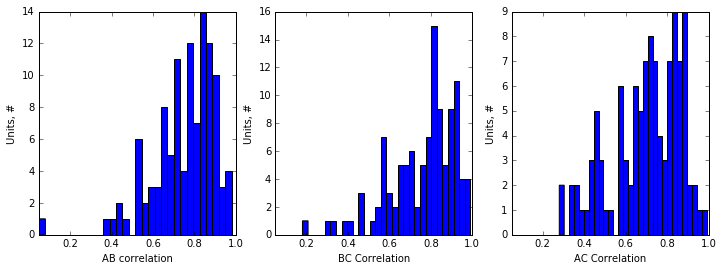

In [181]:
fig = figure(figsize=(12, 4))
bins = 30

x_min = np.array([AB_corr.min(), AB_corr.min(), AB_corr.min()]).min()

ax = fig.add_subplot(131)
ax.set_xlim(x_min, 1)
ax.set_xlabel('AB correlation')
ax.set_ylabel('Units, #')
ax.axvline(0, color='red')
a1 = ax.hist(AB_corr, bins)

ax = fig.add_subplot(132)
ax.set_xlim(x_min, 1)
ax.set_xlabel('BC Correlation')
ax.set_ylabel('Units, #')
ax.axvline(0, color='red')
a1 = ax.hist(BC_corr, bins)

ax = fig.add_subplot(133)
ax.set_xlim(x_min, 1)
ax.set_xlabel('AC Correlation')
ax.set_ylabel('Units, #')
ax.axvline(0, color='red')
a1 = ax.hist(AC_corr, bins)


# Correlation histograms without stable PFs

In [267]:
#stable_fields['2019-11-19_08-18-21']

## ratio of stable / remapping fields

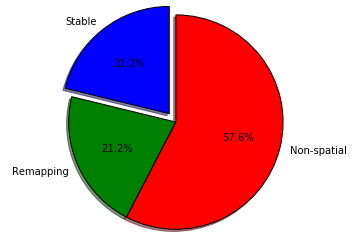

In [191]:
labels = 'Stable', 'Remapping', 'Non-spatial'
sizes = [len(stable_units_filter), len(AB_corr), len(all_units)]
explode = (0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


# Field numbers - no change

In [201]:
num_fields[:, 0].mean(), num_fields[:, 1].mean(), num_fields[:, 2].mean()

(1.3727272727272728, 1.290909090909091, 1.3454545454545455)

# Spike raster plots

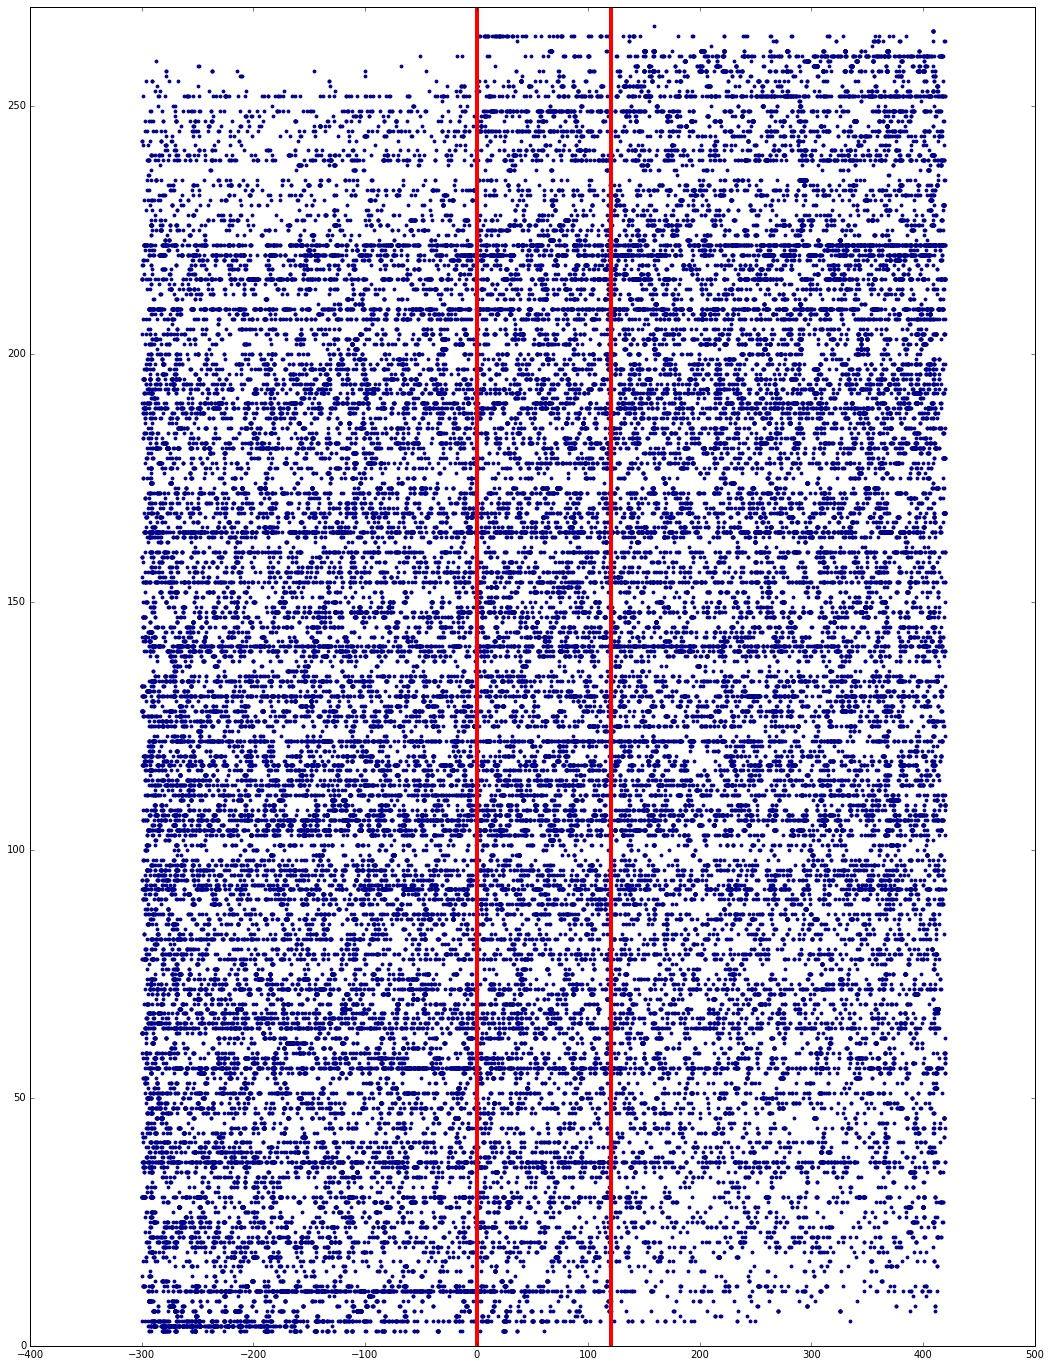

In [246]:
# -------- sorting ------------------
rank = []
for i, st in enumerate(A_spiketrains):
    lA = len(A_spiketrains[i])
    lB = len(B_spiketrains[i])
    rank_i = (lA - lB)/(lA + lB) if (lA + lB) > 0 else 100
    rank.append(rank_i)

index = np.argsort(np.array(rank))

# ---------- spike raster plot ----------

fig = figure(figsize=(18, 24))

ax = fig.add_subplot(111)
ax.set_ylim(0, len(A_spiketrains) + 5)
ax.axvline(0, color='red', lw=4)
ax.axvline(120, color='red', lw=4)

times_A = []
times_AB = []
times_B = []
duration_to_show = 300

for pos, i in enumerate([int(x) for x in index]):
    traj = trajs[i]
    duration = traj[-1][0] - traj[0][0]
    if duration < 1150:
        shift = 300
    elif duration < 1400:
        shift = 360
    else:
        shift = 420
    
    # ----------- A period NO GAIN --------------
    
    idxs_A = np.where((traj[:, 0] - traj[0][0] > shift - duration_to_show) & (traj[:, 0] - traj[0][0] < shift))
    idxs_A = np.intersect1d(A_spiketrains[i], idxs_A)
    times = traj[idxs_A][:, 0] - traj[0][0] - shift
    values = np.zeros(len(times)) - pos + 1 + len(B_spiketrains)
    ax.scatter(times, values, s=8, color='darkblue')
    times_A += list(times)

    # ------------- AB period NO GAIN -> 1.5x GAIN --------
        
    #shift -= 20  # for better visualization
    times = traj[AB_spiketrains[i]][:, 0] - traj[0][0] - shift
    values = np.zeros(len(times)) - pos + 1 + len(B_spiketrains)
    ax.scatter(times, values, s=8, color='darkblue')
    times_AB += list(times)
    
    # B period 1.5x GAIN
        
    #shift -= 20  # for better visualization
    idxs_B = np.where((traj[:, 0] - traj[0][0] > shift + 120) & (traj[:, 0] - traj[0][0] < shift + 120 + duration_to_show))
    idxs_B = np.intersect1d(B_spiketrains[i], idxs_B)
    times = traj[idxs_B][:, 0] - traj[0][0] - shift
    values = np.zeros(len(times)) - pos + 1 + len(B_spiketrains)
    ax.scatter(times, values, s=8, color='darkblue')
    times_B += list(times)

(array([ 1093.,  1237.,  1086.,  1222.,  1019.,   932.,   903.,   944.,
          878.,   976.,  1048.,   998.,  1035.,  1096.,  1153.,  1013.,
         1038.,  1096.,  1046.,  1123.,   835.,  1036.,   938.,   999.,
         1332.,  1084.,  1016.,   991.,  1204.,   932.]),
 array([ 120.00099993,  130.00093327,  140.0008666 ,  150.00079994,
         160.00073328,  170.00066662,  180.00059996,  190.00053329,
         200.00046663,  210.00039997,  220.00033331,  230.00026665,
         240.00019999,  250.00013332,  260.00006666,  270.        ,
         279.99993334,  289.99986668,  299.99980001,  309.99973335,
         319.99966669,  329.99960003,  339.99953337,  349.99946671,
         359.99940004,  369.99933338,  379.99926672,  389.99920006,
         399.9991334 ,  409.99906673,  419.99900007]),
 <a list of 30 Patch objects>)

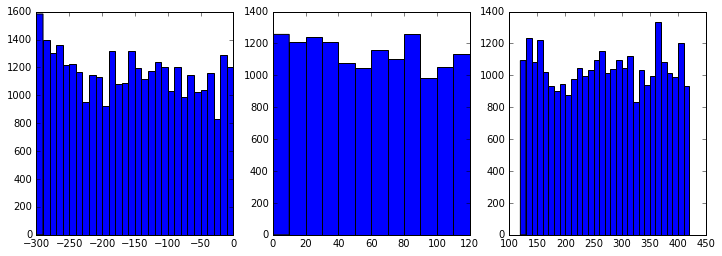

In [247]:
fig = figure(figsize=(12, 4))

ax = fig.add_subplot(131)
ax.hist(times_A, bins=int(duration_to_show/10))

ax = fig.add_subplot(132)
ax.hist(times_AB, bins=12)

ax = fig.add_subplot(133)
ax.hist(times_B, bins=int(duration_to_show/10))

In [248]:
h_A, edges_A = np.histogram(times_A, bins=int(duration_to_show/10))
h_AB, edges_AB = np.histogram(times_AB, bins=12)
h_B, edges_B = np.histogram(times_B, bins=int(duration_to_show/10))

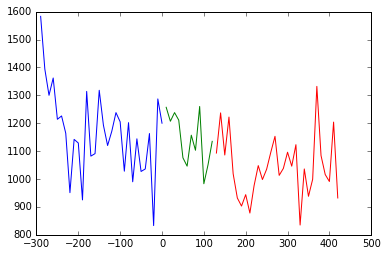

In [249]:
plt.plot(edges_A[1:], h_A)
plt.plot(edges_AB[1:], h_AB)
plt.plot(edges_B[1:], h_B)
# edges_B, h_B

In [242]:
t_min = np.array(times_AB).min()
t_max = np.array(times_AB).max()

t_norm = (np.array(times_AB) - t_min) / t_max

scipystats.kstest(t_norm, 'uniform')

KstestResult(statistic=0.11498145993390529, pvalue=0.0)

# Middle fields have more vlength / length change in B?

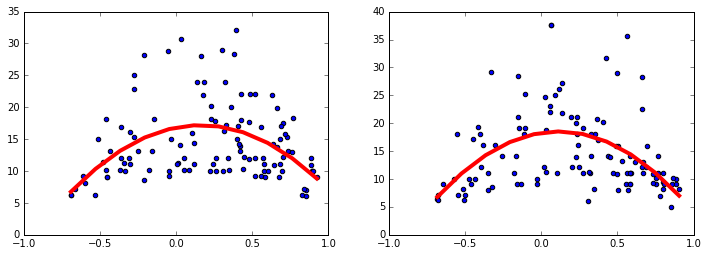

In [276]:
# Only for B, vlength versus COMy

field_lengths_A = []   # maybe works
field_lengths_B = []   # maybe works
lengths_delta_AB = []  # does not really work - no change in vlength
A_C_COM_delta = []

for session_id, units in stable_fields.items():
    for unit_name, data in units.items():
        for field_A_id, A_X_matches in data.items():
            
            # 0 - field A id, 1 - field X id, 2 - % overlap, 3 - Vert length A
            # 4 - Vert length X, 5 - A COMy, 6 - X COMy, 7 - A-X COM shift

            A_B_match = A_X_matches[0]
            A_C_match = A_X_matches[0]
            
            field_lengths_A.append([A_B_match[5], A_B_match[3]])
            field_lengths_B.append([A_B_match[6], A_B_match[4]])
            lengths_delta_AB.append([A_B_match[5], A_B_match[4] - A_B_match[3]])
            A_C_COM_delta.append([A_C_match[5], A_C_match[7]])

field_lengths_A = np.array(field_lengths_A)  
field_lengths_B = np.array(field_lengths_B)  
lengths_delta_AB = np.array(lengths_delta_AB)
A_C_COM_delta = np.array(A_C_COM_delta)

fig = figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.set_xlim(-1, 1)
ax.scatter(field_lengths_A[:, 0], field_lengths_A[:, 1])

a, b, c = np.polyfit(field_lengths_A[:, 0], field_lengths_A[:, 1], 2)

y_min = field_lengths_A[:, 0].min()
y_max = field_lengths_A[:, 0].max()

x_space = np.linspace(y_min, y_max, 11)
y_space = [(a * (x**2) + b * x + c) for x in x_space]

ax.plot(x_space, y_space, linewidth=4, color='red')


ax = fig.add_subplot(122)
ax.set_xlim(-1, 1)
ax.scatter(field_lengths_B[:, 0], field_lengths_B[:, 1])

a, b, c = np.polyfit(field_lengths_B[:, 0], field_lengths_B[:, 1], 2)

y_min = field_lengths_B[:, 0].min()
y_max = field_lengths_B[:, 0].max()

x_space = np.linspace(y_min, y_max, 11)
y_space = [(a * (x**2) + b * x + c) for x in x_space]

ax.plot(x_space, y_space, linewidth=4, color='red')

# Middle fields have more shift A-C?

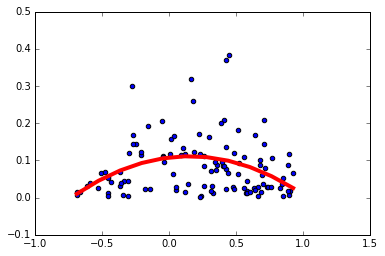

In [283]:
fig = figure(figsize=(6, 4))

ax = fig.add_subplot(111)
ax.scatter(A_C_COM_delta[:, 0], np.abs(A_C_COM_delta[:, 1]))

a, b, c = np.polyfit(A_C_COM_delta[:, 0], np.abs(A_C_COM_delta[:, 1]), 2)

y_min = A_C_COM_delta[:, 0].min()
y_max = A_C_COM_delta[:, 0].max()

x_space = np.linspace(y_min, y_max, 11)
y_space = [(a * (x**2) + b * x + c) for x in x_space]

ax.plot(x_space, y_space, linewidth=4, color='red')

In [278]:
scipystats.linregress(A_C_COM_delta[:, 0], A_C_COM_delta[:, 1])

LinregressResult(slope=-0.017704584912141903, intercept=-0.015379570602061337, rvalue=-0.071204499623967299, pvalue=0.45154979055628275, stderr=0.023435031650762897)

In [59]:
get_animal = lambda x: [y[0] for y in sessions_list if y[1] == x][0]

    
min_sic = 0.2
min_mfr = 0.3

all_u = []
to_link = []
for session_id, unit_MFR in meanFR.items():
    for name, data in unit_MFR.items():
        all_u.append([session_id, name])
        
        sic_filt = data['A']['sic'][0] > min_sic or data['B']['sic'][0] > min_sic or data['C']['sic'][0] > min_sic
        mfr_filt = data['A']['mfr'] > min_mfr or data['B']['mfr'] > min_mfr or data['C']['mfr'] > min_mfr
        
        if sic_filt and mfr_filt:
            img_item = [
                get_animal(session_id), 
                session_id, 
                name.split('_')[0], 
                name.split('_')[1]
            ]
            to_link.append(img_item)
    
    
dest_folder = '/home/andrey/storage2/andrey/data/projects/22_VFG/all'
create_symlinks(dest_folder, source, to_link)
len(to_link)

224

In [51]:
sessions_list

[('003281', '2019-11-17_15-34-04'),
 ('003281', '2019-11-20_15-15-05'),
 ('003282', '2019-11-08_17-35-28'),
 ('003282', '2019-11-19_08-18-21'),
 ('003282', '2019-11-07_22-05-39'),
 ('003281', '2019-11-07_21-41-36'),
 ('003282', '2019-11-17_15-59-58'),
 ('003282', '2019-11-20_11-41-38'),
 ('003282', '2019-12-03_19-51-34'),
 ('003282', '2019-11-12_15-29-13'),
 ('003282', '2019-11-13_12-54-37'),
 ('003282', '2019-11-11_13-04-49'),
 ('003282', '2019-11-13_22-18-19'),
 ('003282', '2019-11-22_10-16-28'),
 ('003282', '2019-11-12_20-24-17'),
 ('003282', '2019-11-26_21-58-57')]

In [53]:
get_animal('2019-11-08_17-35-28')

'003282'